# Objective :

* **Find turns using "Position-Based Turn Detection"**
* **Find turning speeds**

Based upon the following research paper (chapter 4) : https://ir.lib.uwo.ca/cgi/viewcontent.cgi?referer=https://www.google.com/&httpsredir=1&article=6640&context=etd

In [139]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [140]:
df = pd.read_csv("datasets/company_raw.csv")

In [141]:
df.head()

,Unnamed: 0,heading,id,img_front,lat,lon,speed,timestamp
0,7191,NE,DB002,NaN,18.528308,73.873303,0.0,1537409201000
1,7192,NE,DB002,img_front_DB002_2018_09_20_07_36_41_369000.jpg,18.528308,73.873303,0.0,1537409201369
2,7193,NE,DB002,img_front_DB002_2018_09_20_07_36_41_563000.jpg,18.528308,73.873303,0.0,1537409201563
3,7194,NE,DB002,img_front_DB002_2018_09_20_07_36_41_830000.jpg,18.528308,73.873303,0.0,1537409201830
4,7195,NE,DB002,NaN,18.528308,73.873303,0.0,1537409202000


In [142]:
df.columns = ["index", "heading", "id", "img_front", "lat", "lon", "speed", "timestamp"]
df.head()

,index,heading,id,img_front,lat,lon,speed,timestamp
0,7191,NE,DB002,NaN,18.528308,73.873303,0.0,1537409201000
1,7192,NE,DB002,img_front_DB002_2018_09_20_07_36_41_369000.jpg,18.528308,73.873303,0.0,1537409201369
2,7193,NE,DB002,img_front_DB002_2018_09_20_07_36_41_563000.jpg,18.528308,73.873303,0.0,1537409201563
3,7194,NE,DB002,img_front_DB002_2018_09_20_07_36_41_830000.jpg,18.528308,73.873303,0.0,1537409201830
4,7195,NE,DB002,NaN,18.528308,73.873303,0.0,1537409202000


In [143]:
df.shape

(60492, 8)

df.info()

In [207]:
print(df["id"].unique())
print(df["heading"].unique())

['DB002']
['NE']


## 1.  Detect turns without rotating axes

Expected output : all turns except acute turns will be detected

In [208]:
df_trip = df[100:250]

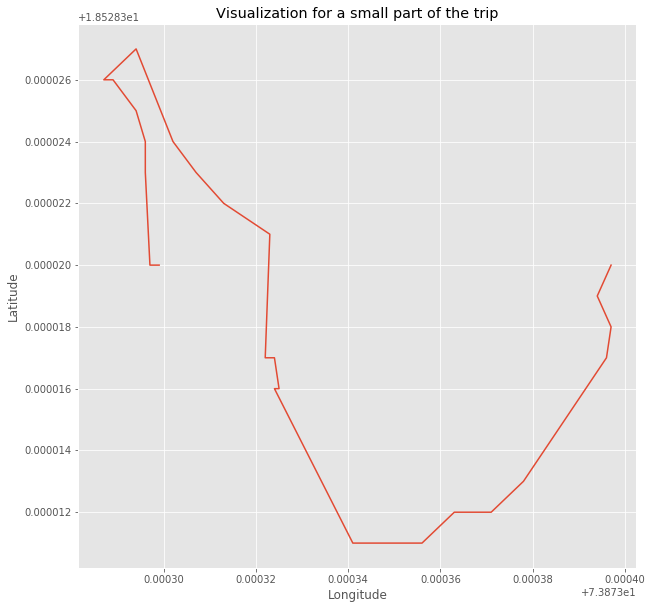

In [177]:
plt.figure(figsize=(10,10))
plt.style.use("ggplot")
plt.title("Visualization for a small part of the trip")
plt.plot(df_trip["lon"], df_trip["lat"])
plt.ticklabel_format(axis = "both" , style='plain')
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

In [147]:
df_trip = df_trip[["index","lat","lon","speed","timestamp"]]

In [148]:
df_trip.head()

,index,lat,lon,speed,timestamp
100,7291,18.52832,73.873299,0.094452,1537409224283
101,7292,18.52832,73.873299,0.094452,1537409224548
102,7293,18.52832,73.873299,0.094452,1537409224845
103,7294,18.52832,73.873297,0.094452,1537409225000
104,7295,18.52832,73.873297,0.094452,1537409225132


In [178]:
def detect_turn(df_trip):
    
    df_turns = pd.DataFrame(columns=["start_index", "end_index", "start_lat", "start_lon", "end_lat", "end_lon"])
    
    df_start = df_trip[0:1]
    lat1 = df_trip["lat"].iloc[0]
    lon1 = df_trip["lon"].iloc[0]
    change = False
    
    for i in range(len(df_trip)):
        
        lat2 = df_trip["lat"].iloc[i]
        lon2 = df_trip["lon"].iloc[i]
        delta_lat = lat2 - lat1
        delta_lon = lon2 - lon1
        
        if(delta_lat != 0) or (delta_lon != 0):
            # Change in lat or long detected
            if change == False:
                # Possible start of a turn
                change = True
                m1 = delta_lat * delta_lon
                df_start = df_trip[i:i+1]
                
                lat1 = lat2
                lon1 = lon2
                
            else:
                # Possible end of turn
                df_end = df_trip[i:i+1]
                m2 = delta_lat * delta_lon
                
                if m1*m2 <= 0:
                    # Turn detected
                    start_index = df_start["index"].iloc[0]
                    end_index = df_end["index"].iloc[0]
                    #start_time = df_start["timestamp"].iloc[0]
                    #print(df_start["timestamp"].iloc[0])
                    start_lat = df_start["lat"].iloc[0]
                    start_lon = df_start["lon"].iloc[0]
                    end_lat = df_end["lat"].iloc[0]
                    end_lon = df_end["lon"].iloc[0]
                    
                    df_turns = df_turns.append({"start_index":start_index, "end_index":end_index,
                                                "start_lat":start_lat, "start_lon":start_lon,
                                                "end_lat":end_lat, "end_lon":end_lon},
                                                ignore_index=True)
                    change = False
                
                else:
                    # Turn not detected, possible start of new turn
                    df_start = df_end
                    m1 = m2
                    lat1 = lat2
                    lon1 = lon2
            
        else:
            lat1 = lat2
            lon1 = lon2
        
    return df_turns

In [180]:
df_turns = detect_turn(df_trip)

In [181]:
df_turns

,start_index,end_index,start_lat,start_lon,end_lat,end_lon
0,7294.0,7298.0,18.528320,73.873297,18.528323,73.873296
1,7299.0,7305.0,18.528323,73.873296,18.528324,73.873296
2,7306.0,7310.0,18.528324,73.873296,18.528325,73.873294
3,7314.0,7319.0,18.528326,73.873289,18.528326,73.873287
4,7320.0,7326.0,18.528326,73.873287,18.528327,73.873294
5,7327.0,7352.0,18.528327,73.873294,18.528324,73.873302
6,7370.0,7414.0,18.528321,73.873323,18.528317,73.873322
7,7415.0,7418.0,18.528317,73.873322,18.528317,73.873324
8,7419.0,7422.0,18.528317,73.873324,18.528316,73.873325
9,7423.0,7431.0,18.528316,73.873325,18.528316,73.873324


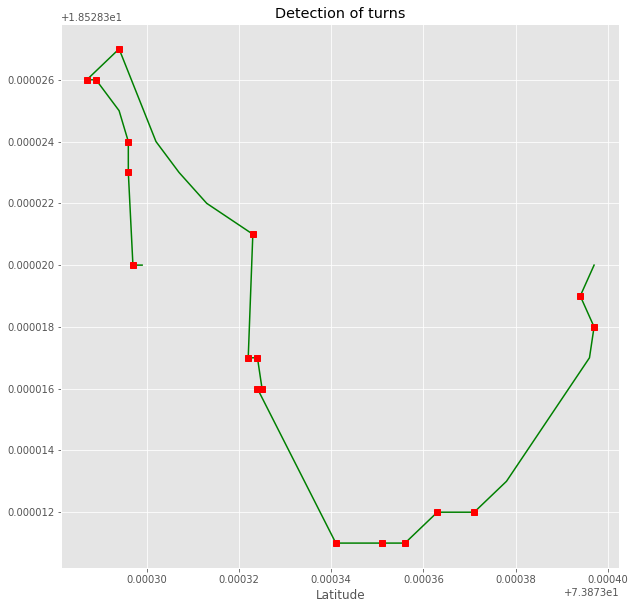

In [189]:
plt.figure(figsize=(10,10))
plt.title("Detection of turns")
plt.plot(df_trip["lon"],df_trip["lat"],"green")
plt.plot(df_turns["start_lon"], df_turns["start_lat"], "rs")
plt.xlabel("Longitude")
plt.xlabel("Latitude")
plt.show()

* **Red squares indicate turning points**

Lets plot some more parts of dataframe to see if the algorithm performs properly

In [197]:
def plot_turns(df_trip, df_turns):
    plt.figure(figsize=(10,10))
    plt.title("Detection of turns")
    plt.plot(df_trip["lon"],df_trip["lat"],"green")
    plt.plot(df_turns["start_lon"], df_turns["start_lat"], "rs")
    plt.xlabel("Longitudes")
    plt.xlabel("Latitudes")
    plt.show()   

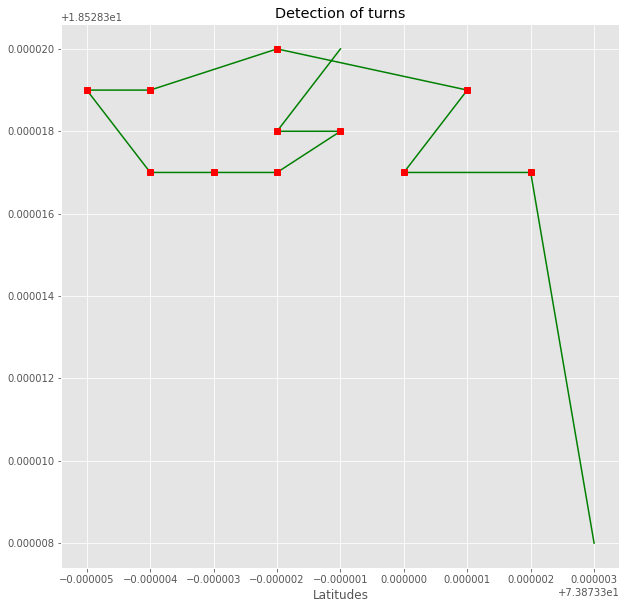

In [201]:
df_trip2 = df[0:100]
df_turns = detect_turn(df_trip2)
plot_turns(df_trip2, df_turns)

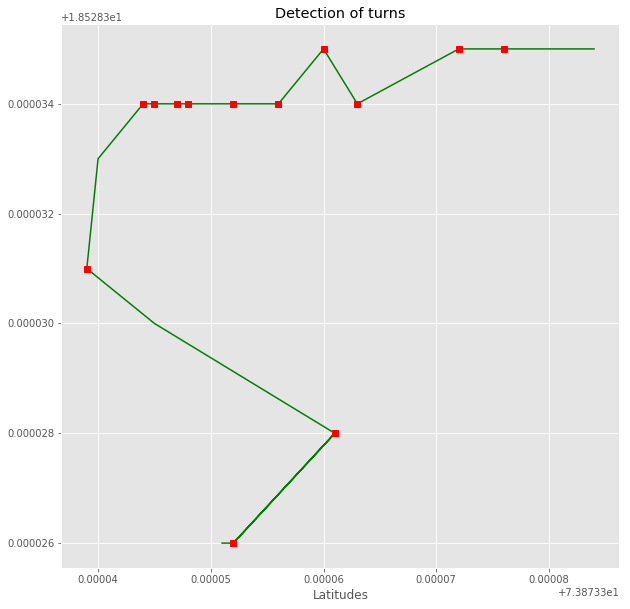

In [204]:
df_trip2 = df[400:500]
df_turns = detect_turn(df_trip2)
plot_turns(df_trip2, df_turns)

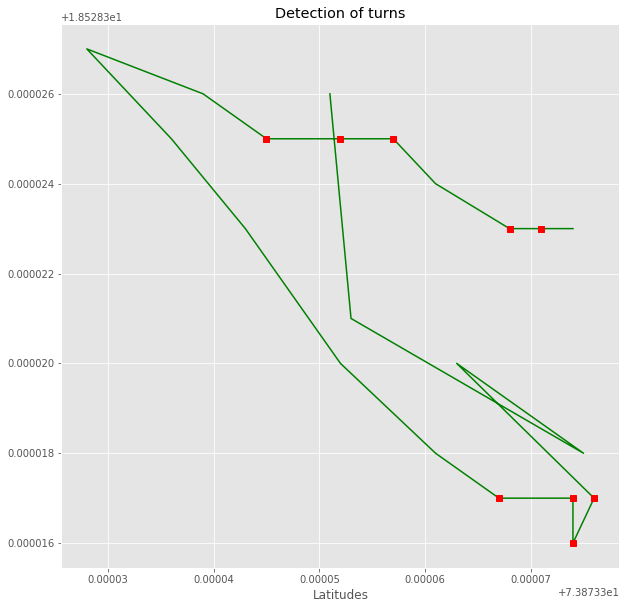

In [205]:
df_trip2 = df[300:400]
df_turns = detect_turn(df_trip2)
plot_turns(df_trip2, df_turns)

* **As we can see acute turns are not detected. We have to rotate axes by 45 degrees to fix that (page 27 of the research paper)**